# Project Setup

## Please install the following libraries

- !pip install tensorflow

## Project Files
- Please, download the project files from: TBD

## GitHub Link
- GitHub Repository: https://github.com/mlgomez0/advanced_python_project/tree/main/notebooks

## Set the variables

- run_pandas_profiling: equal True means to create the Pandas Profiling which takes time, False means you will use the profile attached with this report

In [248]:
create_pandas_profiling = False
run_models=True

## Please do the following imports

In [273]:
import csv
import pandas as pd
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats import chi2_contingency
from wordcloud import WordCloud
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
import plotly.express as px
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from ydata_profiling import ProfileReport
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
import pickle
import re

# Dataset Exploration and Cleaning

For this report, we used posts in Reddit (The code can be found in previous report), a social media platform where people can create communities (subreddits) to discuss several topics. For this report, we focused on communities on climate change and collected those posts that are new and hot in the respective subreddit.

The selected subreddits are: 'climatechange', 'climate_science', 'climate', 'environment', 'GlobalClimateChange', 'climate_change', 'ClimateChangeSurprise'

To gather the dataset, we used the Reddit API. We created a developer account to get the access credentials to work with this API. Additionally, we used a Python package called Prawn ("Python Reddit API Wrapper"). This wrapper facilitates the interactions with the API.

The final dataset has the following features:

- Title: The post title
- Score: It is a net score that equals upvotes minus downvotes for a particular Reddit post
- Author: Author of the post 
- Time: Data of the post
- Comments: Number of comments done to the post
- UpvoteRatio: It is the ratio between upvotes and total votes
- PostId: Unique identifier for the vote
- Subreddit: Name of the subreddit
- is_nsfw: The content is not safe for work
- SelfText: Is the text in the post
- IsSelfText: This boolean tells if the post has self text (In some cases, there is a link or picture instead)
- IsPinned: Refers to whether a post is pinned to a user's profile page
- IsStickied: Indicates the post is pinned to a subreddit
- IsLocked: This boolean indicates if users are able to make new comments on the post
- Sentiment_hf: Sentiment analysis of textual data using Hugging Face (Previous work)
- Sentiment_v: Sentiment analysis of textual data using Vader (Previous work)


In [148]:
df = pd.read_csv('climate_change_sentiment.csv')

In [149]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15975 entries, 0 to 15974
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Title         15975 non-null  object 
 1   Score         15975 non-null  int64  
 2   Autor         15518 non-null  object 
 3   Time          15975 non-null  float64
 4   Comments      15975 non-null  int64  
 5   UpvoteRatio   15975 non-null  float64
 6   PostId        15975 non-null  object 
 7   Subreddit     15975 non-null  object 
 8   is_nsfw       15975 non-null  bool   
 9   SelfText      2398 non-null   object 
 10  IsSelfText    15975 non-null  bool   
 11  IsPinned      15975 non-null  bool   
 12  IsStickied    15975 non-null  bool   
 13  IsLocked      15975 non-null  bool   
 14  Sentiment_v   15975 non-null  object 
 15  Sentiment_hf  15975 non-null  object 
dtypes: bool(5), float64(2), int64(2), object(7)
memory usage: 1.4+ MB


Note:

As we can see, the SelfText column has more than 75% null values. Therefore, we'll going to drop that column. Also, the PostId column has just random unique values. Consequently, we will drop that column as well. Finally, 'Sentiment_v' will be removed; we will use 'Sentiment_hf' instead for sentiment.

In [150]:
# Droping columns
df = df.drop(['PostId', 'SelfText', 'Sentiment_v'],axis=1)

In [151]:
# create pandas profiling
if create_pandas_profiling:
    profile = ProfileReport(df, title="Profiling Report")
    profile.to_file("pandas_profiling_ClimateChange2.html")

The pandas report showed the following Alerts:
    
- IsPinned has constant value
- Score is highly overall correlated with Comments
- Subreddit is highly overall correlated with IsSelfText
- IsSelfText is highly overall correlated with Subreddit
- is_nsfw is highly imbalanced (99.4%)
- IsStickied is highly imbalanced (99.4%)
- IsLocked is highly imbalanced (97.9%)
- Autor has 457 (2.9%) missing values
- Score has 278 (1.7%) zeros
- Comments has 3545 (22.2%) zeros

In [16]:
# check the unique values in each columns
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Unique values in {column}: {unique_values}")

Unique values in Title: ["I'm afraid climate change is going to kill me! Help!"
 'The r/climatechange Verified User Flair Program'
 'How come some environmentalists are against carbon capture and storage?'
 ... 'Berkeley Lab scientists identify new driver behind Arctic warming'
 'Snowfall less sensitive to warming in Karakoram than in Himalayas due to a unique seasonal cycle'
 'Exposed: Corporate cash is the lifeblood of climate change denial on Capitol Hill']
Unique values in Score: [ 718   30   75 ... 2667 2649 2577]
Unique values in Autor: ['Will_Power' 'technologyisnatural' 'SnooMarzipans7682' ... 'rspix000'
 'madreader121' 'xabby']
Unique values in Time: [1.55010375e+09 1.66111520e+09 1.69798679e+09 ... 1.41548544e+09
 1.41369371e+09 1.41036847e+09]
Unique values in Comments: [ 534   14  296   26   30   34  124    1    2  169  117   19    7  416
   96   57  676    0    9   13    3    5   67   33   93  372  365   16
   43   12   73  315  130   42   88  913  226   21  199   44   11 

In [152]:
# checking nulls in the data
df.isna().sum()

Title             0
Score             0
Autor           457
Time              0
Comments          0
UpvoteRatio       0
Subreddit         0
is_nsfw           0
IsSelfText        0
IsPinned          0
IsStickied        0
IsLocked          0
Sentiment_hf      0
dtype: int64

We remove author as this should not be a predictor for the model, we don't want the model to learn about the author of the posts as the tool is meant to be used by any author.

In [153]:
df.drop('Autor', axis=1, inplace=True)

We remove UpvoteRatio and Comments as this columns have information that the user of the model won't have to make a prediction.

In [154]:
df.drop('UpvoteRatio', axis=1, inplace=True)
df.drop('Comments', axis=1, inplace=True)

In [155]:
# With this, the data has no nulls
df.isna().sum()

Title           0
Score           0
Time            0
Subreddit       0
is_nsfw         0
IsSelfText      0
IsPinned        0
IsStickied      0
IsLocked        0
Sentiment_hf    0
dtype: int64

In [156]:
# Creating Categorical Score
df['Score_cat'], bin_edges = pd.qcut(df['Score'], q=4, labels=False, retbins=True)

Text(0, 0.5, 'Frequency')

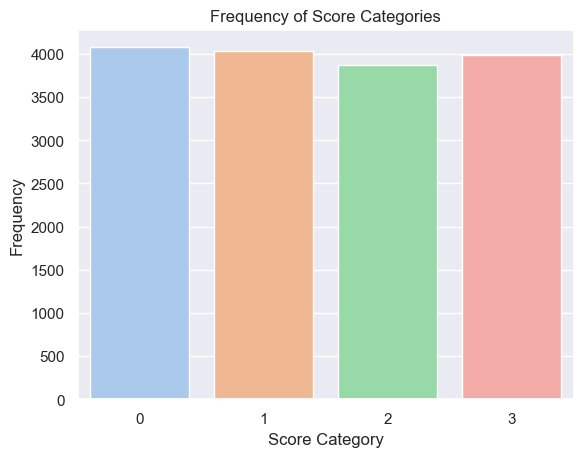

In [157]:
# Plot of Score Categories
sns.countplot(data=df, x='Score_cat')
sns.color_palette("pastel")
plt.title("Frequency of Score Categories")
plt.xlabel("Score Category")
plt.ylabel("Frequency")

As can be seen the categories are balanced

In [158]:
# eliminate Score
df.drop("Score", axis=1, inplace=True)

In [159]:
df.head()

,Title,Time,Subreddit,is_nsfw,IsSelfText,IsPinned,IsStickied,IsLocked,Sentiment_hf,Score_cat
0,I'm afraid climate change is going to kill me!...,1.550104e+09,climatechange,False,True,False,True,False,negative,3
1,The r/climatechange Verified User Flair Program,1.661115e+09,climatechange,False,True,False,True,False,positive,2
2,How come some environmentalists are against ca...,1.697987e+09,climatechange,False,True,False,False,False,negative,2
3,Solar and wind are better than nuclear,1.698006e+09,climatechange,False,True,False,False,False,positive,1
4,When will we hit 2 degrees of global warming?,1.698013e+09,climatechange,False,True,False,False,False,negative,0


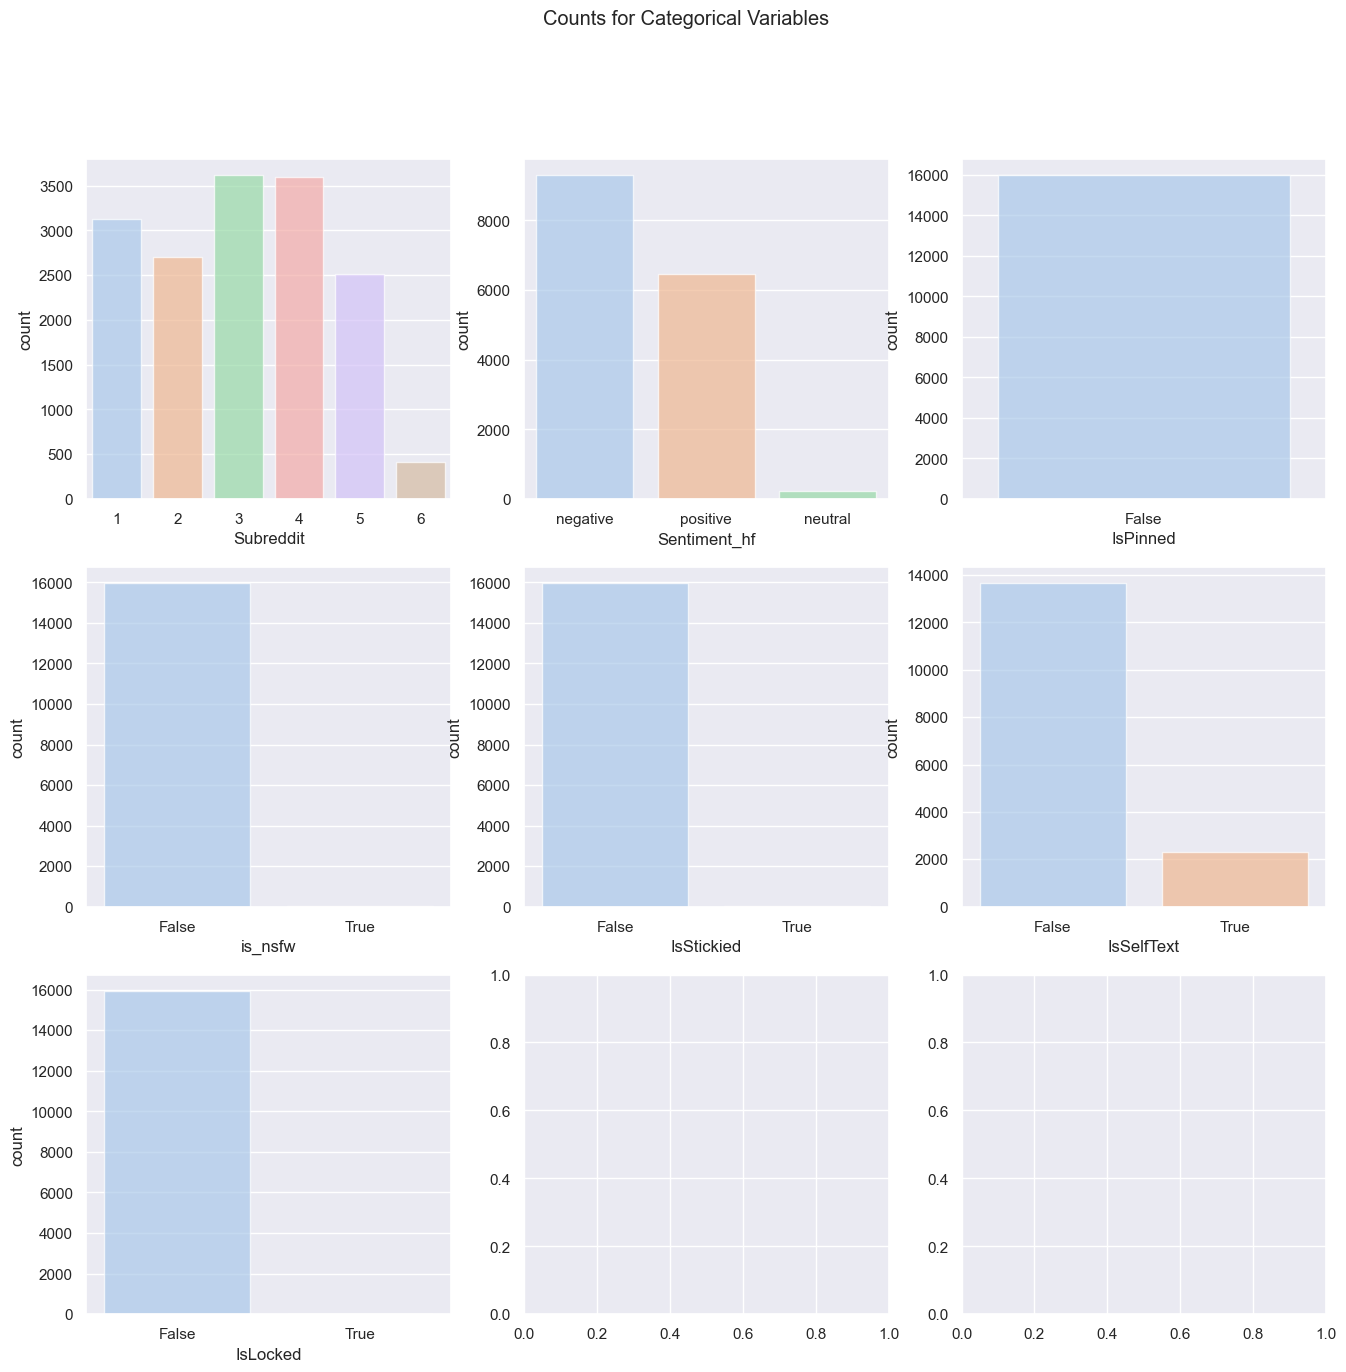

In [160]:
# checking all categorical columns

fig, axes = plt.subplots(3, 3, figsize=(16, 15))

sns.countplot(ax=axes[0][0], data=df, x='Subreddit', alpha=0.7)
axes[0][0].set_xticklabels([1, 2, 3, 4, 5, 6])
sns.countplot(ax=axes[0][1], data=df, x='Sentiment_hf', alpha=0.7)
sns.countplot(ax=axes[0][2], data=df, x='IsPinned', alpha=0.7)
sns.countplot(ax=axes[1][0], data=df, x='is_nsfw', alpha=0.7)
sns.countplot(ax=axes[1][1], data=df, x='IsStickied', alpha=0.7)
sns.countplot(ax=axes[1][2], data=df, x='IsSelfText', alpha=0.7)
sns.countplot(ax=axes[2][0], data=df, x='IsLocked', alpha=0.7)
sns.color_palette("pastel")
fig.suptitle("Counts for Categorical Variables")

plt.show()

As can be seen in the graph above, there are many categorical values with the same value for all the records or highly imbalance. Therefore, we will remove those columns.

In [147]:
df.drop(['IsPinned', 'is_nsfw', 'IsStickied', 'IsLocked'], axis=1, inplace=True)

In [161]:
df.head()

,Title,Time,Subreddit,is_nsfw,IsSelfText,IsPinned,IsStickied,IsLocked,Sentiment_hf,Score_cat
0,I'm afraid climate change is going to kill me!...,1.550104e+09,climatechange,False,True,False,True,False,negative,3
1,The r/climatechange Verified User Flair Program,1.661115e+09,climatechange,False,True,False,True,False,positive,2
2,How come some environmentalists are against ca...,1.697987e+09,climatechange,False,True,False,False,False,negative,2
3,Solar and wind are better than nuclear,1.698006e+09,climatechange,False,True,False,False,False,positive,1
4,When will we hit 2 degrees of global warming?,1.698013e+09,climatechange,False,True,False,False,False,negative,0


## Time column

In [162]:
# Now cleaning the Time column's data
df['Time'] = pd.to_datetime(df['Time'], unit='s')

df['Year'] = df['Time'].dt.year
df['Month'] = df['Time'].dt.month
df['Day'] = df['Time'].dt.day
df['Hour'] = df['Time'].dt.hour

# Feature enginering two new columns

df['TimeOfDay'] = pd.cut(df['Time'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['Night', 'Morning', 'Afternoon', 'Evening'])

df['IsWeekend'] = df['Time'].dt.weekday // 5 == 1

In [163]:
df.drop(columns=['Time'], inplace=True)

In [164]:
#check again nulls
df.isna().sum()

Title             0
Subreddit         0
is_nsfw           0
IsSelfText        0
IsPinned          0
IsStickied        0
IsLocked          0
Sentiment_hf      0
Score_cat         0
Year              0
Month             0
Day               0
Hour              0
TimeOfDay       570
IsWeekend         0
dtype: int64

In [165]:
#Imputing nulls in new created column TimeOfDay
df['TimeOfDay'].fillna(df['TimeOfDay'].mode().iloc[0], inplace=True)

In [51]:
# checking back nulls
df.isna().sum()

Title           0
Subreddit       0
IsSelfText      0
Sentiment_hf    0
Score_cat       0
Year            0
Month           0
Day             0
Hour            0
TimeOfDay       0
IsWeekend       0
dtype: int64

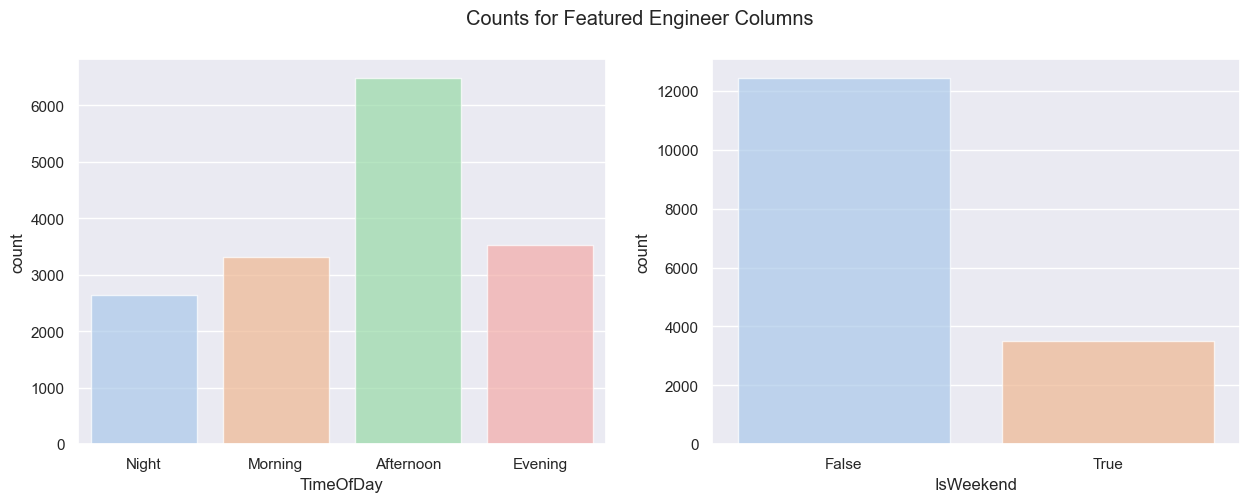

In [166]:
# Checking new categorical columns

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(ax=axes[0], data=df, x='TimeOfDay', alpha=0.7)
sns.countplot(ax=axes[1], data=df, x='IsWeekend', alpha=0.7)
sns.color_palette("pastel")

fig.suptitle("Counts for Featured Engineer Columns")

plt.show()

In [167]:
df.head()

,Title,Subreddit,is_nsfw,IsSelfText,IsPinned,IsStickied,IsLocked,Sentiment_hf,Score_cat,Year,Month,Day,Hour,TimeOfDay,IsWeekend
0,I'm afraid climate change is going to kill me!...,climatechange,False,True,False,True,False,negative,3,2019,2,14,0,Afternoon,False
1,The r/climatechange Verified User Flair Program,climatechange,False,True,False,True,False,positive,2,2022,8,21,20,Evening,True
2,How come some environmentalists are against ca...,climatechange,False,True,False,False,False,negative,2,2023,10,22,14,Afternoon,True
3,Solar and wind are better than nuclear,climatechange,False,True,False,False,False,positive,1,2023,10,22,20,Evening,True
4,When will we hit 2 degrees of global warming?,climatechange,False,True,False,False,False,negative,0,2023,10,22,22,Evening,True


# Feature Extraction and Scaling

In [249]:
# spliting data before doing transformations to avoid data leakage

Y_df = df['Score_cat']
X_df = df.drop('Score_cat', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, test_size=0.2, random_state=42)

In [250]:
# function to process textual data
def preprocess_textual_data(data, text_column='Title'):
    """
    Preprocesses text data and returns a TF-IDF matrix.
    """
    corpus = []
    for i in range(len(data)):
        text = re.sub(r'\W', ' ', str(data[text_column].iloc[i]))
        text = text.lower()
        text = re.sub(r'^br$', ' ', text)
        text = re.sub(r'\s+br\s+',' ', text)
        text = re.sub(r'\s+[a-z]\s+', ' ', text)
        text = re.sub(r'^b\s+', '', text)
        text = re.sub(r'\s+', ' ', text)
        corpus.append(text)
    return corpus

In [251]:
# vectorizing textual data (Title) with TF-IDF
clean_x_train = preprocess_textual_data(X_train)
clean_x_test = preprocess_textual_data(X_test)
vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.6, stop_words=stopwords.words('english'))
tfidf = vectorizer.fit(clean_x_train)
tfidf_X_train = tfidf.transform(clean_x_train).toarray()
tfidf_X_test = tfidf.transform(clean_x_test).toarray()

In [252]:
# Creating a DataFrame with the vectorized text
df_text_tfidf_train = pd.DataFrame(tfidf_X_train, columns=tfidf.get_feature_names_out())
df_text_tfidf_test = pd.DataFrame(tfidf_X_test, columns=tfidf.get_feature_names_out())

In [253]:
# Pipeline to transform features

cat_nominal = ['Subreddit']
cat_ordinal = ['Sentiment_hf', 'TimeOfDay']
cat_binary = ['IsWeekend', 'IsSelfText']

numerical_cols = ['Year', 'Month', 'Day', 'Hour']

def preprocess_and_vectorize_titles(data):
    return preprocess_and_vectorize(data, text_column='Title')


pipeline_cat_nomical = Pipeline(steps=[
    ('one-hot', OneHotEncoder(drop='if_binary'))
])

pipeline_cat_nomical = Pipeline(steps=[
    ('one-hot', OneHotEncoder())
])

pipeline_cat_binary = Pipeline(steps=[
    ('one-hot', OneHotEncoder(drop='if_binary'))
])


pipeline_cat_ordinal = Pipeline(steps=[
      ('ord', OrdinalEncoder())
])


preprocessor = ColumnTransformer(transformers=[
    ('nom', pipeline_cat_nomical, cat_nominal),
    ('ord', pipeline_cat_ordinal, cat_ordinal),
    ('binary', pipeline_cat_binary, cat_binary),
    ('passthrough', 'passthrough', numerical_cols)
])

# Transformed no textual columns
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [254]:
# Print the transformed shapes
print(f"X_train_transformed.shape: {X_train.shape}")
print(f"X_test_transformed.shape: {X_test.shape}")

X_train_transformed.shape: (12780, 14)
X_test_transformed.shape: (3195, 14)


In [255]:
features = preprocessor.get_feature_names_out()

In [256]:
# create data frames without textual data
df_train = pd.DataFrame(X_train, columns=features)
df_test = pd.DataFrame(X_test, columns=features)

print(f"No textual df.shape: {df_train.shape}")
print(f"No textual df.shape: {df_test.shape}")

No textual df.shape: (12780, 14)
No textual df.shape: (3195, 14)


In [257]:
# concatenate the transformed dataframes
X_final_train = pd.concat([df_train, df_text_tfidf_train], axis=1)
X_final_test = pd.concat([df_test, df_text_tfidf_test], axis=1)

# Modeling

In [258]:
# Funtion to plot confusion matrix
def confusion_matrix_graph(y, y_pred, label):
    cm_decision_tree_classifier = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(cm_decision_tree_classifier, index=['Actual 0', 'Actual 1', 'Actual 2', 'Actual 3'], columns=['Predicted 0', 'Predicted 1', 'Predicted 2', 'Predicted 3'])
    sns.heatmap(cm_df, annot=True, cmap='Blues', cbar=False, )
    plt.title(f"Confusion matrix for {label}")
    
#Function to save the trained model
def save_model_pickle(file_name, model):
    file_name = file_name + '.pkl'
    with open(file_name, 'wb') as file:
        pickle.dump(model, file)

#Function to retrieve the trained model
def retrieve_model_pickle(file_name):
    file_name = file_name + '.pkl'
    with open(file_name, 'rb') as file:
        model = pickle.load(file)
        return model
    
# Function to extract feature importance

def get_top_features(model, df, num): 
    important_features = model.feature_importances_
    top_indices = np.argsort(important_features)[-num:][::-1]
    top_features = df.columns[top_indices]
    print(f'The {num} most important features are: {list(top_features)}')
    
# function to print metrics
def print_metrics(y_test, y_pred, label):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print evaluation metrics
    print(f"Accuracy for {label}: {accuracy}")
    print(f"Precision for {label}: {precision}")
    print(f"Recall for {label}: {recall}")
    print(f"F1-score for {label}: {f1}")
    return accuracy, precision, recall, f1

In [259]:
# Setting up a dataframe to store the results
df_models_explorations = pd.DataFrame({
    "model": ["NN", "KNN", "SVM", "GNB", "XGBoost", "AdaBoost", "Decision Tree", "GB"],
    "accuracy_test": [0, 0, 0, 0, 0, 0, 0, 0],
    "accuracy_train": [0, 0, 0, 0, 0, 0, 0, 0],
    "precision_test": [0, 0, 0, 0, 0, 0, 0, 0],
    "precision_train": [0, 0, 0, 0, 0, 0, 0, 0],
    "recall_test": [0, 0, 0, 0, 0, 0, 0, 0],
    "recall_train": [0, 0, 0, 0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0, 0, 0, 0],
    "F1_test": [0, 0, 0, 0, 0, 0, 0, 0]
})
df_models_explorations.set_index('model', inplace=True)
df_models_explorations

,accuracy_test,accuracy_train,precision_test,precision_train,recall_test,recall_train,F1_test
model,,,,,,,
NN,0,0,0,0,0,0,0
KNN,0,0,0,0,0,0,0
SVM,0,0,0,0,0,0,0
GNB,0,0,0,0,0,0,0
XGBoost,0,0,0,0,0,0,0
AdaBoost,0,0,0,0,0,0,0
Decision Tree,0,0,0,0,0,0,0
GB,0,0,0,0,0,0,0


## Gradient Boosting Classifier

In [260]:
if run_models:
    gb_clf = GradientBoostingClassifier(learning_rate=0.1)
    gb_clf.fit(X_final_train, y_train)
    save_model_pickle('gb_clf', gb_clf)
else:
    gb_clf = retrieve_model_pickle('gb_clf')


y_pred_test = gb_clf.predict(X_final_test)
y_pred_train = gb_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['GB', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['GB', 'precision_test'] = precision_te
df_models_explorations.loc['GB', 'recall_test'] = recall_te
df_models_explorations.loc['GB', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['GB', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['GB', 'precision_train'] = precision_tr
df_models_explorations.loc['GB', 'recall_train'] = recall_tr
df_models_explorations.loc['GB', 'F1_train'] = f1_tr

Accuracy for Test: 0.6181533646322379
Precision for Test: 0.6206549506971478
Recall for Test: 0.6181533646322379
F1-score for Test: 0.6150904625994251
---------------------------------
Accuracy for Train: 0.673943661971831
Precision for Train: 0.6799701970269539
Recall for Train: 0.673943661971831
F1-score for Train: 0.6718900754640011


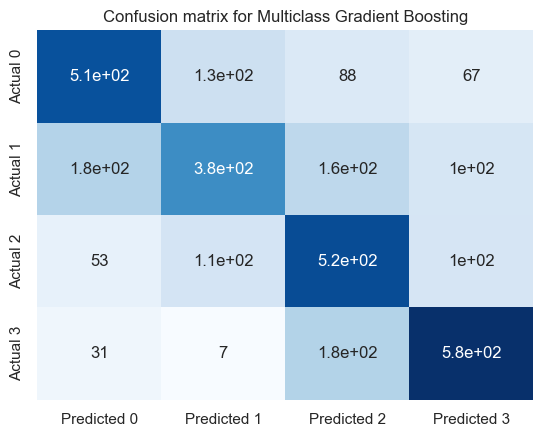

In [261]:
confusion_matrix_graph(y_test, y_pred_test, "Multiclass Gradient Boosting")

## Support Vector Machine

In [263]:
# train multiclass SVC
if run_models:
    svc_clf = SVC(probability=True, random_state=42, decision_function_shape='ovo')
    svc_clf.fit(X_final_train, y_train)
    save_model_pickle('SVM1', svc_clf)
else:
    svc_clf = retrieve_model_pickle('SVM1')

y_pred_test = svc_clf.predict(X_final_test)
y_pred_train = svc_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['SVM', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['SVM', 'precision_test'] = precision_te
df_models_explorations.loc['SVM', 'recall_test'] = recall_te
df_models_explorations.loc['SVM', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['SVM', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['SVM', 'precision_train'] = precision_tr
df_models_explorations.loc['SVM', 'recall_train'] = recall_tr
df_models_explorations.loc['SVM', 'F1_train'] = f1_tr

Accuracy for Test: 0.24726134585289514
Precision for Test: 0.061138173152985024
Recall for Test: 0.24726134585289514
F1-score for Test: 0.09803586610980534
---------------------------------
Accuracy for Train: 0.25727699530516435
Precision for Train: 0.06619145231325356
Recall for Train: 0.25727699530516435
F1-score for Train: 0.10529334833997764


/Users/marygomez/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/marygomez/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


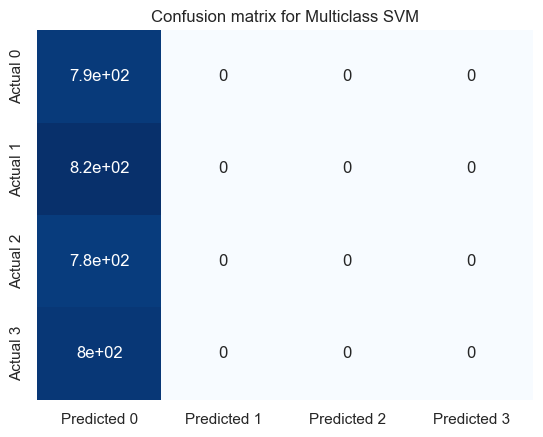

In [264]:
confusion_matrix_graph(y_test, y_pred_test, "Multiclass SVM")

As can be see, the model predicted all categories as 0.

## XGBoost Classifier

In [266]:
if run_models:
    xgb_clf = xgb.XGBClassifier(
        learning_rate=0.1,
        n_estimators=50,
        max_depth=3,
        subsample=1.0,
        colsample_bytree=1.0,
        random_state=42
    )
    xgb_clf.fit(X_final_train, y_train)
    save_model_pickle('xgb_clf', xgb_clf)
else:
    xgb_clf = retrieve_model_pickle('xgb_clf')


y_pred_test = xgb_clf.predict(X_final_test)
y_pred_train = xgb_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc['XGBoost', 'accuracy_test'] = accuracy_te
df_models_explorations.loc['XGBoost', 'precision_test'] = precision_te
df_models_explorations.loc['XGBoost', 'recall_test'] = recall_te
df_models_explorations.loc['XGBoost', 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc['XGBoost', 'accuracy_train'] = accuracy_tr
df_models_explorations.loc['XGBoost', 'precision_train'] = precision_tr
df_models_explorations.loc['XGBoost', 'recall_train'] = recall_tr
df_models_explorations.loc['XGBoost', 'F1_train'] = f1_tr

Accuracy for Test: 0.5483568075117371
Precision for Test: 0.558769017426821
Recall for Test: 0.5483568075117371
F1-score for Test: 0.5449688631768526
---------------------------------
Accuracy for Train: 0.5619718309859155
Precision for Train: 0.5779450339467455
Recall for Train: 0.5619718309859155
F1-score for Train: 0.5592137696246354


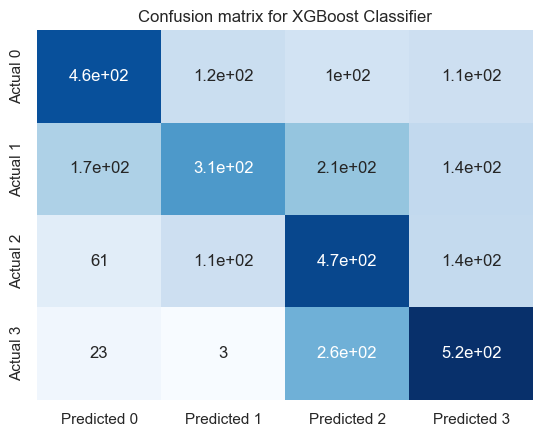

In [267]:
confusion_matrix_graph(y_test, y_pred_test, "XGBoost Classifier")

## Ada Boost Classifier

In [271]:
# Create the AdaBoostClassifier
if run_models:
    ada_clf = AdaBoostClassifier(
        n_estimators=100,
        learning_rate=1.0,
        random_state=42
    )

    ada_clf.fit(X_final_train, y_train)
    save_model_pickle('ada_clf', ada_clf)
else:
    ada_clf = retrieve_model_pickle('ada_clf')


y_pred_test = ada_clf.predict(X_final_test)
y_pred_train = ada_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc["AdaBoost", 'accuracy_test'] = accuracy_te
df_models_explorations.loc["AdaBoost", 'precision_test'] = precision_te
df_models_explorations.loc["AdaBoost", 'recall_test'] = recall_te
df_models_explorations.loc["AdaBoost", 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc["AdaBoost", 'accuracy_train'] = accuracy_tr
df_models_explorations.loc["AdaBoost", 'precision_train'] = precision_tr
df_models_explorations.loc["AdaBoost", 'recall_train'] = recall_tr
df_models_explorations.loc["AdaBoost", 'F1_train'] = f1_tr

Accuracy for Test: 0.4557120500782473
Precision for Test: 0.4949457236695072
Recall for Test: 0.4557120500782473
F1-score for Test: 0.46392464837103875
---------------------------------
Accuracy for Train: 0.4877934272300469
Precision for Train: 0.5293047024981208
Recall for Train: 0.4877934272300469
F1-score for Train: 0.49481754435926373


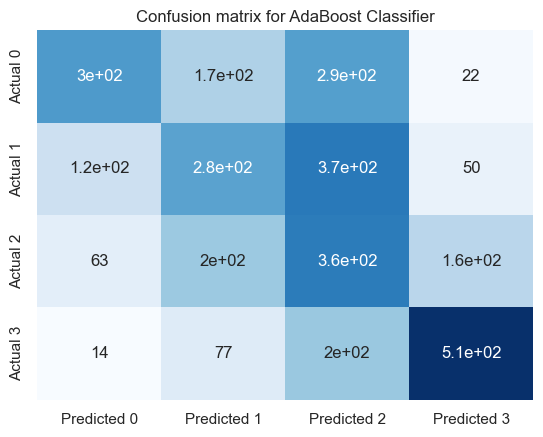

In [272]:
confusion_matrix_graph(y_test, y_pred_test, "AdaBoost Classifier")

## Decision Tree Classifier

In [68]:
if run_models:
    dt_clf = DecisionTreeClassifier(random_state=42)
    dt_clf.fit(X_final_train, y_train)
    save_model_pickle('dt_clf', dt_clf)
else:
    dt_clf = retrieve_model_pickle('dt_clf')

y_pred_test = dt_clf.predict(X_final_test)
y_pred_train = dt_clf.predict(X_final_train)

# metrics test set
accuracy_te, precision_te, recall_te, f1_te = print_metrics(y_test, y_pred_test, "Test")
df_models_explorations.loc["AdaBoost", 'accuracy_test'] = accuracy_te
df_models_explorations.loc["AdaBoost", 'precision_test'] = precision_te
df_models_explorations.loc["AdaBoost", 'recall_test'] = recall_te
df_models_explorations.loc["AdaBoost", 'F1_test'] = f1_te

print("---------------------------------")

# metrics train set
accuracy_tr, precision_tr, recall_tr, f1_tr = print_metrics(y_train, y_pred_train, "Train")
df_models_explorations.loc["AdaBoost", 'accuracy_train'] = accuracy_tr
df_models_explorations.loc["AdaBoost", 'precision_train'] = precision_tr
df_models_explorations.loc["AdaBoost", 'recall_train'] = recall_tr
df_models_explorations.loc["AdaBoost", 'F1_train'] = f1_tr

Accuracy: 0.6672508763144717
Confusion Matrix:
[[724 203  71  16]
 [308 513 178  19]
 [ 89 204 589  86]
 [ 13  16 126 839]]
Precision: 0.6672508763144717
Recall: 0.6672508763144717
F1-score: 0.6672508763144717


In [69]:
save_model_pickle('dt_clf', dt_clf)

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

# Create a Sequential model
model = Sequential()

# Add layers to the model
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(4, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=256, validation_data=(X_test, y_test))

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)
print("Loss on test data:", loss)
print("Accuracy on test data:", accuracy)

# Display model summary
model.summary()

2023-12-01 14:47:58.825637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/30
47/47 [==============================] - 4s 26ms/step - loss: 1.5387 - accuracy: 0.3186 - val_loss: 1.3834 - val_accuracy: 0.2787
Epoch 2/30
47/47 [==============================] - 1s 15ms/step - loss: 1.2542 - accuracy: 0.4233 - val_loss: 1.3847 - val_accuracy: 0.2932
Epoch 3/30
47/47 [==============================] - 1s 15ms/step - loss: 1.1418 - accuracy: 0.4714 - val_loss: 1.4099 - val_accuracy: 0.2952
Epoch 4/30
47/47 [==============================] - 1s 14ms/step - loss: 1.0664 - accuracy: 0.5096 - val_loss: 1.4153 - val_accuracy: 0.3092
Epoch 5/30
47/47 [==============================] - 1s 14ms/step - loss: 1.0110 - accuracy: 0.5361 - val_loss: 1.4300 - val_accuracy: 0.2989
Epoch 6/30
47/47 [==============================] - 1s 14ms/step - loss: 0.9623 - accuracy: 0.5605 - val_loss: 1.3505 - val_accuracy: 0.3590
Epoch 7/30
47/47 [==============================] - 1s 14ms/step - loss: 0.9088 - accuracy: 0.5924 - val_loss: 1.2843 - val_accuracy: 0.3998
Epoch 8/30
47

 dense_8 (Dense)             (None, 4)                 68        
                                                                 
Total params: 476660 (1.82 MB)
Trainable params: 473876 (1.81 MB)
Non-trainable params: 2784 (10.88 KB)
_________________________________________________________________


In [73]:
save_model_pickle('NN_model', model)